# Counterfactual policy simulations

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import funs
import figs
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Deduction

In [2]:
LS = {}
GovS = {}
x = np.linspace(0,2,11)

### Single model

In [3]:
SingleEst = SMD.load_est(name='Single')
Single = RetirementClass(**SingleEst)
LS['Single'] = figs.resolve(Single,vars=['d'],ages=[58,72],fradrag=[0,1])
GovS['Single'] = figs.resolve(Single,vars=['GovS'],ages=[57,110],fradrag=x)
del Single

### Couple model

In [4]:
CoupleEst,SingleEst = SMD.load_est(name='Couple',couple=True)
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
LS['Couple'] = figs.resolve_c(Couple, vars=['d'], ages=[58,72], fradrag=[0,1])
GovS['Couple'] = figs.resolve_c(Couple, vars=['GovS'], ages=[57,110], fradrag=x)
#del Couple

### Restricted Couple model

In [5]:
Couple.par.phi_0_male = 0
Couple.par.phi_0_female = 0
Couple.par.phi_1 = 0
LS['RestCouple'] = figs.resolve_c(Couple, vars=['d'], ages=[58,72], fradrag=[0,1])
GovS['RestCouple'] = figs.resolve_c(Couple, vars=['GovS'], ages=[57,110], fradrag=x)
del Couple

### Plots

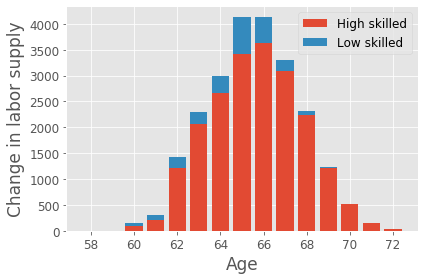

In [45]:
figs.LS_bar(LS['Single'],ages=[58,72],save=False)

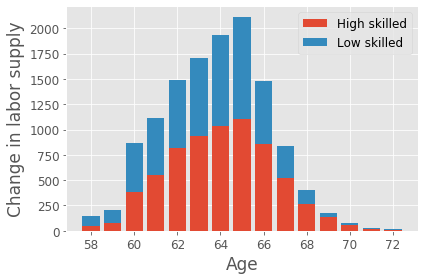

In [46]:
figs.LS_bar(LS['Couple'],ages=[58,72],save=False)

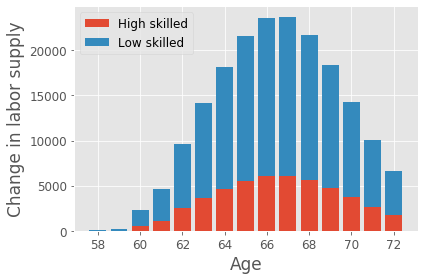

In [47]:
figs.LS_bar(LS['RestCouple'],ages=[58,72],save=False)

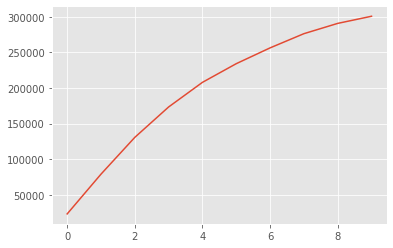

In [48]:
g = np.array(GovS['RestCouple']['GovS'])
plt.plot(g[1:]-g[0])

In [49]:
g

array([-194092.00924227, -171140.4110659 , -115250.22380497,
        -63520.20426992,  -20797.08042698,   13812.80798862,
         40062.60731302,   62265.61208108,   82226.02878084,
         96694.76585507,  106738.94313604])

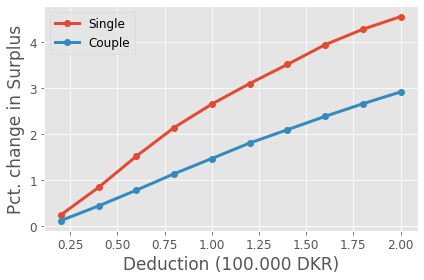

In [50]:
figs.GovS_plot(x[1:],[GovS['Single'],GovS['Couple']],
               labels=['Single','Couple'],save=False)

### Retirement age

In [56]:
LS = {}
GovS = {}
age = (65,62,60)
ages_dict_one = {'oap_age':   [i+age[0] for i in range(2)],
                 'two_year':  [i+age[1] for i in range(2)],
                 'erp_age':   [i+age[2] for i in range(2)]}
ages_dict = {'oap_age':   [i+age[0] for i in range(7)],
             'two_year':  [i+age[1] for i in range(7)],
             'erp_age':   [i+age[2] for i in range(7)]}

In [58]:
SingleEst = SMD.load_est(name='Single')
Single = RetirementClass(**SingleEst)
LS['Single'] = figs.resolve(Single,vars=['d'],ages=[58,72],**ages_dict_one)
GovS['Single'] = figs.resolve(Single,vars=['GovS'],ages=[57,110],**ages_dict)
del Single

In [59]:
CoupleEst,SingleEst = SMD.load_est(name='Couple',couple=True)
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
LS['Couple'] = figs.resolve_c(Couple, vars=['d'], ages=[58,72], **ages_dict_one)
GovS['Couple'] = figs.resolve_c(Couple, vars=['GovS'], ages=[57,110], **ages_dict)
#del Couple

In [60]:
Couple.par.phi_0_male = 0
Couple.par.phi_0_female = 0
Couple.par.phi_1 = 0
LS['RestCouple'] = figs.resolve_c(Couple, vars=['d'], ages=[58,72], **ages_dict_one)
GovS['RestCouple'] = figs.resolve_c(Couple, vars=['GovS'], ages=[57,110], **ages_dict)
del Couple

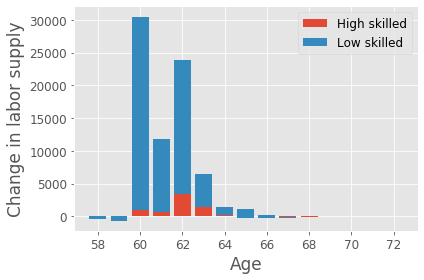

In [61]:
figs.LS_bar(LS['Single'],ages=[58,72],save=False)

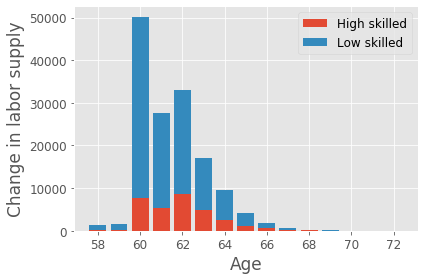

In [62]:
figs.LS_bar(LS['Couple'],ages=[58,72],save=False)

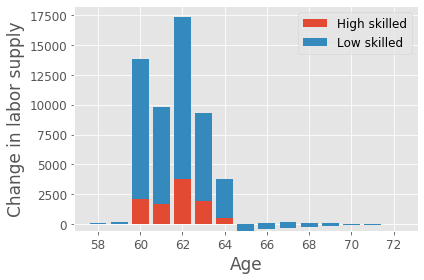

In [63]:
figs.LS_bar(LS['RestCouple'],ages=[58,72],save=False)

In [66]:
GovS['Couple']

{'GovS': [-2158135.201918799,
  -1888404.4799659613,
  -1616510.8843235206,
  -1339579.4700107386,
  -1068584.2414503398,
  -803936.8835616173,
  -547876.7745623746]}

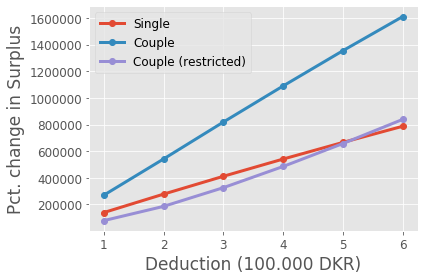

In [85]:
figs.GovS_plot(np.arange(1,7),[GovS['Single'],GovS['Couple'],GovS['RestCouple']],
               labels=['Single','Couple','Couple (restricted)'],save=False)

In [3]:
SingleEst = SMD.load_est(name='Single')
Single = RetirementClass(**SingleEst)
RetAge['Single'] = figs.resolve(Single,vars=['d','GovS'],recompute=True,**ages_dict)
del Single

In [4]:
#CoupleEst,SingleEst = SMD.load_est(name='Couple',couple=True)
CoupleEst = {}
SingleEst = {}
CoupleEst['simN'] = int(1e5)
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
RetAge['Couple'] = figs.resolve_c(Couple, vars=['d','GovS'], recompute=True, **ages_dict)
#del Couple

In [32]:
Couple.par.oap_age = 65
Couple.par.two_year = 62
Couple.par.erp_age = 60
Couple.solve(recompute=True)
Couple.simulate()

In [34]:
Couple.par.oap_age

65

In [35]:
Couple.par.T_oap

8

In [41]:
def rename(G_lst):
    G_lst[0]['label'] = ['High skilled']
    G_lst[1]['label'] = ['Base']
    G_lst[2]['label'] = ['Low skilled']

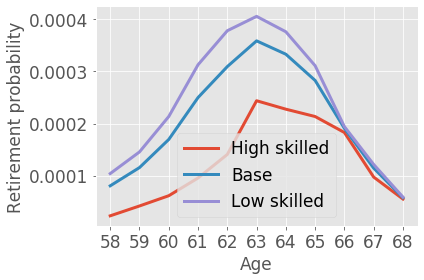

In [42]:
G_hs = figs.retirement_probs_c(Couple,ma=0,ST_w=[1,3])
G_base = figs.retirement_probs_c(Couple,ma=0)
G_ls = figs.retirement_probs_c(Couple,ma=0,ST_w=[0,2])
rename([G_hs,G_base,G_ls])
figs.MyPlot([G_hs,G_base,G_ls],linewidth=3,save=False)

C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


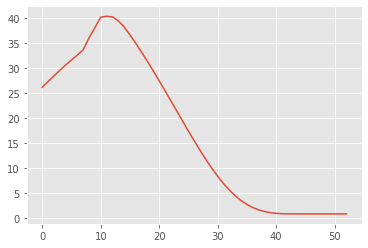

In [40]:
plt.plot(np.nanmean(Couple.sim.m,axis=0))

C:\Users\Frederik\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


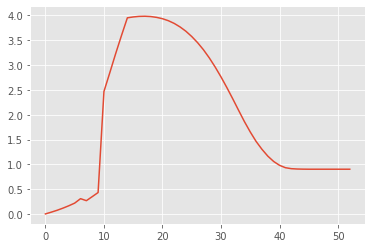

In [39]:
plt.plot(np.nanmean(Couple.sim.c,axis=0))

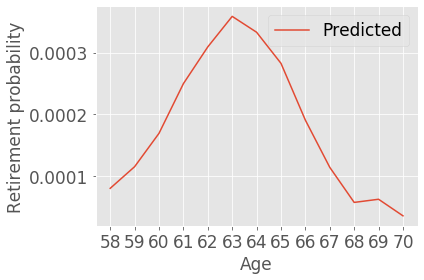

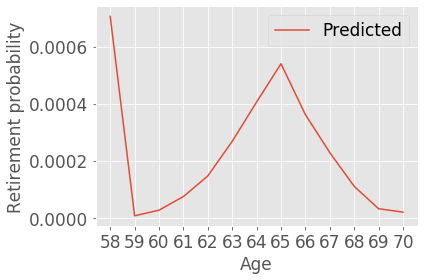

In [33]:
figs.MyPlot(figs.retirement_probs_c(Couple,ma=0,ages=[58,70]), save=False)
figs.MyPlot(figs.retirement_probs_c(Couple,ma=1,ages=[58,70]), save=False)

In [16]:
ages_dict

{'oap_age': [65, 66, 67, 68, 69, 70, 71],
 'two_year': [62, 63, 64, 65, 66, 67, 68],
 'erp_age': [60, 61, 62, 63, 64, 65, 66]}

In [17]:
Couple.par.oap_age

71

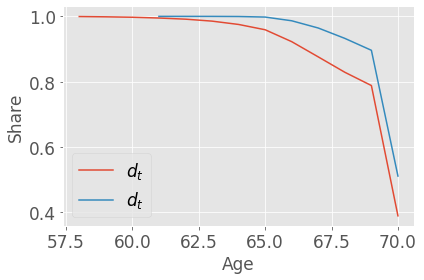

In [31]:
ss = figs.lifecycle_c(Couple,var='d',ages=[58,70])
figs.MyPlot(ss,save=False)

In [30]:
ss

{'y': [array([[1.        ,        nan],
         [0.99950473,        nan],
         [0.99864654,        nan],
         [0.99730757,        nan],
         [0.99495353, 1.        ],
         [0.99146467, 0.99999   ],
         [0.98544057, 0.99993917],
         [0.97526356, 0.99958891],
         [0.95904713, 0.99789151],
         [0.92260372, 0.98652248],
         [0.87597645, 0.96435398],
         [0.82895614, 0.93263764]])],
 'x': array([57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]),
 'xlabel': 'Age',
 'ylabel': 'Share',
 'label': ['$d_t$'],
 'fontsize': 17,
 'labelsize': 17,
 'legendsize': 17,
 'linestyle': ('-',),
 'marker': None}

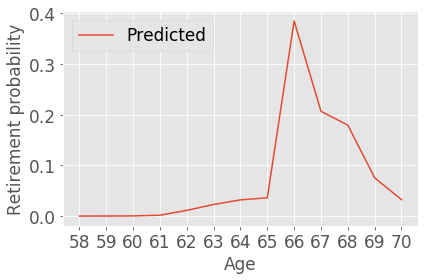

In [25]:
ss = figs.retirement_probs_c(Couple,ma=1,ages=[58,70])
figs.MyPlot(ss,save=False)

In [12]:
d = RetAge['Couple']['d']
G = RetAge['Couple']['GovS']

In [13]:
G

[-2150465.7262970684,
 -1883522.6536321514,
 -1619553.8075020746,
 -1342664.1469294694,
 -1066915.384408714,
 -806891.3265299262,
 -549676.7064654756]

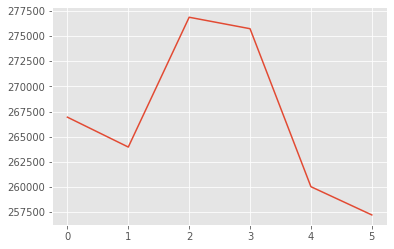

In [15]:
plt.plot(np.diff(G))

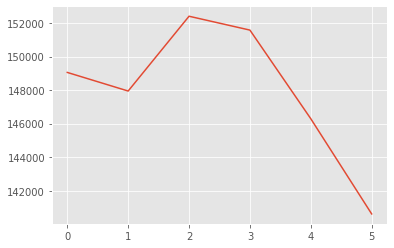

In [10]:
plt.plot(np.diff(d))

In [50]:
Single.solve()
Single.simulate()

In [64]:
Single.par.oap_age = 68
Single.par.erp_age = 63
Single.par.two_year = 65
Single.recompute()
Single.solve()
Single.simulate()

In [77]:
G['label'] = ['Baseline']
G1['label'] = ['+1']
G1['x'] = G1['x']+1
G1['xticks'] = G1['xticks']+1

In [90]:
y = G['y'][0]
y1 = G1['y'][0]

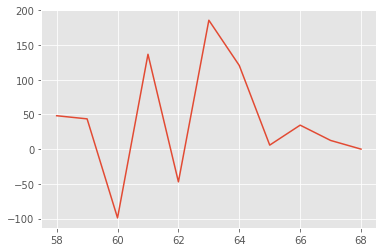

In [97]:
plt.plot(G['x'],(y1/y-1)*100)

In [89]:
G['y']

[array([0.01023229, 0.00427923, 0.31964584, 0.13910121, 0.27506444,
        0.09789874, 0.04320473, 0.03938249, 0.0288967 , 0.02091116,
        0.0136465 ])]

In [88]:
y

array([[0.01023229, 0.00427923, 0.31964584, 0.13910121, 0.27506444,
        0.09789874, 0.04320473, 0.03938249, 0.0288967 , 0.02091116,
        0.0136465 ]])

In [86]:
np.array(G['y'])/np.array(G1['y'])

array([[  0.67480582,   0.69604375, 108.85223533,   0.42236437,
          1.89082875,   0.34988723,   0.45337573,   0.94478113,
          0.74286009,   0.88825372,   0.99933157]])

In [79]:
G

{'y': [array([0.01023229, 0.00427923, 0.31964584, 0.13910121, 0.27506444,
         0.09789874, 0.04320473, 0.03938249, 0.0288967 , 0.02091116,
         0.0136465 ])],
 'x': array([58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]),
 'xticks': array([58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]),
 'xlabel': 'Age',
 'ylabel': 'Retirement probability',
 'label': ['Baseline'],
 'fontsize': 17,
 'labelsize': 17,
 'legendsize': 17,
 'linestyle': ('-',),
 'marker': None}

In [80]:
G1

{'y': [array([0.01516332, 0.00614793, 0.00293651, 0.32933937, 0.14547295,
         0.27980085, 0.09529563, 0.04168424, 0.03889926, 0.02354188,
         0.01365563])],
 'x': array([58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]),
 'xticks': array([58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]),
 'xlabel': 'Age',
 'ylabel': 'Retirement probability',
 'label': ['+1'],
 'fontsize': 17,
 'labelsize': 17,
 'legendsize': 17,
 'linestyle': ('-',),
 'marker': None}

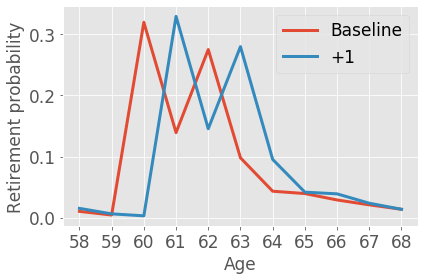

In [78]:
figs.MyPlot([G,G1],linewidth=3,save=False)

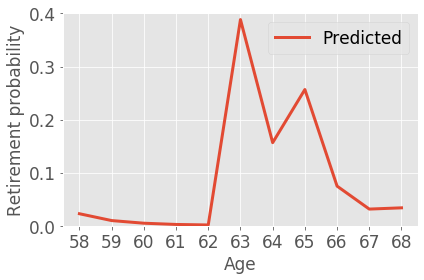

In [65]:
G3 = figs.retirement_probs(Single,MA=[0,1])
figs.MyPlot(G3,linewidth=3,ylim=[0,0.4],save=False)

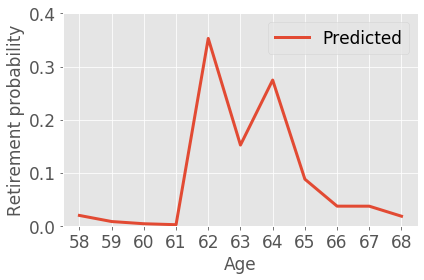

In [63]:
G2 = figs.retirement_probs(Single,MA=[0,1])
figs.MyPlot(G2,linewidth=3,ylim=[0,0.4],save=False)

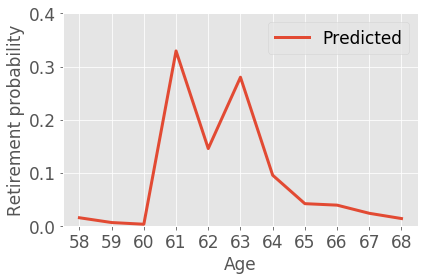

In [61]:
G1 = figs.retirement_probs(Single,MA=[0,1])
figs.MyPlot(G1,linewidth=3,ylim=[0,0.4],save=False)

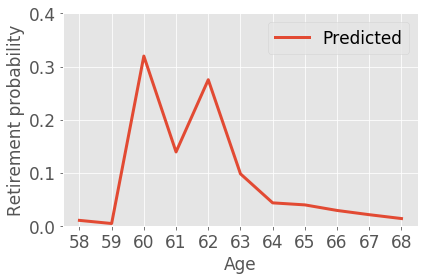

In [54]:
G = figs.retirement_probs(Single,MA=[0,1])
figs.MyPlot(G,linewidth=3,ylim=[0,0.4],save=False)

In [11]:
d = RetAge['Couple']['GovS']

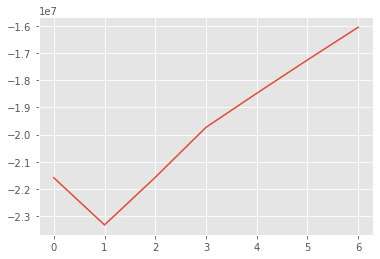

In [12]:
plt.plot(d)

In [6]:
#RestCoupleEst,RestSingleEst = SMD.load_est(name='RestCouple',couple=True)
RestCoupleEst = {}
RestSingleEst = {}
RestCoupleEst['simN'] = 1e6
RestCouple = RetirementClass(couple=True, single_kwargs=RestSingleEst, **RestCoupleEst)
RetAge['RestCouple'] = figs.resolve_c(RestCouple, vars=['d','GovS'], recompute=True, **ages_dict)
del RestCouple

KeyboardInterrupt: 

In [45]:
d = np.array(RetAge['Single']['d'])
G = np.array(RetAge['Single']['GovS'])

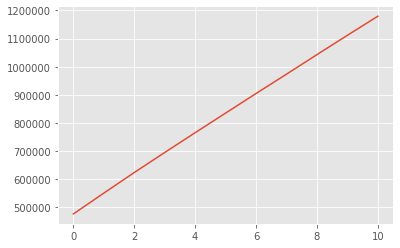

In [47]:
plt.plot(d)

In [42]:
np.diff(G[1:]-G[0])

array([138174.53936411, 133974.77272199, 129334.535188  , 125008.55707448,
       121094.1185182 ])

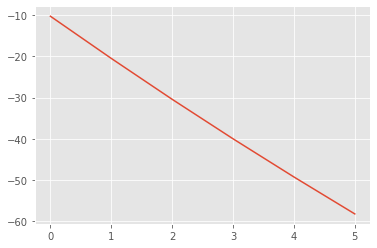

In [39]:
plt.plot((G[1:]/G[0]-1)*100)

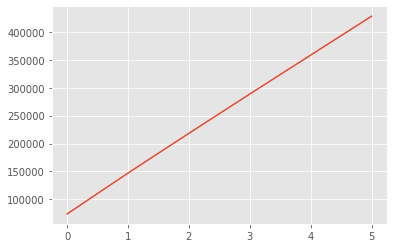

In [23]:
plt.plot(d[1:]-d[0])

In [14]:
d = np.diff(RetAge['Single']['d'])

array([74049., 73149., 71109., 70379., 69613., 69553.])

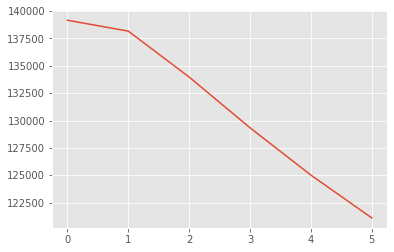

In [16]:
plt.plot(np.diff(RetAge['Single']['GovS']))

Couple model

In [ ]:
CoupleEst,SingleEst = funs.load_est(name='Couple',couple=True)
CoupleEst['simN'] = 1000000
SingleEst['simN'] = 1000000
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
Fradrag['Couple'] = figs.resolve_c(Couple, vars=['d'], recompute=True, fradrag=x)
del Couple

Restricted couple model

In [ ]:
RestCoupleEst,RestSingleEst = funs.load_est(name='RestCouple',couple=True)
RestCoupleEst['simN'] = 1000000
RestSingleEst['simN'] = 1000000
RestCouple = RetirementClass(couple=True, single_kwargs=RestSingleEst, **RestCoupleEst)
Fradrag['RestCouple']=figs.resolve_c(RestCouple, vars=['d'], recompute=True, fradrag=x)
del RestCouple

Results for labor supply

In [ ]:
LS = [Fradrag['Single']['d'], Fradrag['Couple']['d'], Fradrag['RestCouple']['d']]
for j in range(len(LS)):
    LS[j] =[(i/LS[j][0]-1)*100 for i in LS[j][1:]] # list comprehension to compute relative change
names = ['Single model', 'Couple model', 'Restricted Couple model']
xlab = 'Deduction (100.000 DKR)'
ylab = 'Relative change (labor supply)'

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.plot_exp(x[1:],LS,ax,names,xlab,ylab)
fig.tight_layout()
fig.savefig('figs/Experiments/DeductionLaborSupply.png')

Results for goverment surplus

In [ ]:
GS = [Fradrag['Single']['?'], Fradrag['Couple']['?'], Fradrag['RestCouple']['?']]
for j in range(len(GS)):
    GS[j] =[(i/GS[j][0]-1)*100 for i in GS[j][1:]] # list comprehension to compute relative change
names = ['Single model', 'Couple model', 'Restricted Couple model']
xlab = 'Deduction (100.000 DKR)'
ylab = 'Relative change (labor supply)'

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.plot_exp(x[1:],GS,ax,names,xlab,ylab)
fig.tight_layout()
fig.savefig('figs/Experiments/DeductionGovSurplus.png')

Results for welfare

Clean up

In [ ]:
%reset -f

# Increase retirement age

In [ ]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import funs
import figs

# Global modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
oap = 65
two_year = 62
erp = 60
ages_dict = {'oap_age':   [i+oap for i in range(6)],
             'two_year':  [i+two_year for i in range(6)],
             'erp_age':   [i+erp for i in range(6)]}
RetAge = {}

Single model

In [ ]:
SingleEst = funs.load_est(name='Single')
Single = RetirementClass(SingleEst)
RetAge['Single'] = figs.resolve(Single, vars=['d'], recompute=True, **ages_dict)
del Single # to save memory

Couple model

In [ ]:
CoupleEst,SingleEst = funs.load_est(name='Couple',couple=True)
CoupleEst['simN'] = 1000000
SingleEst['simN'] = 1000000
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, **CoupleEst)
RetAge['Couple'] = figs.resolve_c(Couple, vars=['d'], recompute=True, **ages_dict)
del Couple

Restricted couple model

In [ ]:
RestCoupleEst,RestSingleEst = funs.load_est(name='RestCouple',couple=True)
RestCoupleEst['simN'] = 1000000
RestSingleEst['simN'] = 1000000
RestCouple = RetirementClass(couple=True, single_kwargs=RestSingleEst, **RestCoupleEst)
RetAge['RestCouple']=figs.resolve_c(RestCouple, vars=['d'], recompute=True, **ages_dict)
del RestCouple

Results for labor supply

In [ ]:
LS = [RetAge['Single']['d'], [RetAge['Couple']['d'], [RetAge['RestCouple']['d']]
for j in range(len(LS)):
    LS[j] =[(i/LS[j][0]-1)*100 for i in LS[j][1:]] # list comprehension to compute relative change
names = ['Single model', 'Couple model', 'Restricted Couple model']
xlab = 'Deduction (100.000 DKR)'
ylab = 'Relative change (labor supply)'

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.plot_exp(np.arange(1,6),LS,ax,names,xlab,ylab)
fig.tight_layout()
fig.savefig('figs/Experiments/RetAgeLaborSupply.png')

Results for goverment surplus

In [ ]:
GS = [RetAge['Single']['?'], RetAge['Couple']['?'], RetAge['RestCouple']['?']]
for j in range(len(GS)):
    GS[j] =[(i/GS[j][0]-1)*100 for i in GS[j][1:]] # list comprehension to compute relative change
names = ['Single model', 'Couple model', 'Restricted Couple model']
xlab = 'Deduction (100.000 DKR)'
ylab = 'Relative change (labor supply)'

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.plot_exp(np.arange(1,6),GS,ax,names,xlab,ylab)
fig.tight_layout()
fig.savefig('figs/Experiments/RetAgeGovSurplus.png')

Results for welfare

In [ ]:
Yf = [policyF_S['d'], policyF_C['d'], policyF_CR['d']]
for j in range(len(Y)):
    Yf[j] = [(i/Yf[j][0]-1)*100 for i in Yf[j][1:]] # list comprehension to compute relative change
names = ['Single model', 'Couple model', 'Restricted Couple model']
xlab = 'Deduction (100.000 DKR)'
ylab = 'Relative change (labor supply)'

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.plot_exp(x[1:],Y,ax,names,xlab,ylab)
fig.tight_layout()
fig.savefig('figs/Experiments/DeductionLaborSupply.png')

In [2]:
#with open('estimates/Single.pickle', 'rb') as handle:
#    SingleEst = pickle.load(handle)
#Single = RetirementClass(SingleEst)
#Single.solve()
#Single.simulate()

Couple model

In [ ]:
RestCoupleEst,RestSingleEst = funs.load_est(name='RestCouple',couple=True)
RestCouple = RetirementClass(couple=True, single_kwargs=RestSingleEst, **RestCoupleEst)
Fradrag[:,2]=figs.resolve(RestCouple, vars=['d'], recompute=True, fradrag=x)

In [3]:
#with open('estimates/Couple.pickle', 'rb') as handle:
#    CoupleEst = pickle.load(handle)
# Remember the single_kwargs!!!
#Couple = RetirementClass(couple=True)
#Couple.solve()
#Couple.simulate()

Restricted Couple model

In [ ]:
CoupleRestEst,SingleRestEst = funs.load_est(name='CoupleRest',couple=True)
CoupleRest = RetirementClass(couple=True, single_kwargs=SingleRestEst, CoupleRestEst)
CoupleRest.solve()
CoupleRest.simulate()

In [22]:
#with open('estimates/CoupleRest.pickle', 'rb') as handle:
#    CoupleRestEst = pickle.load(handle)
# Remember the single_kwargs!!!
#CoupleRest = RetirementClass(couple=True, phi_0_male=0.0, phi_0_female=0.0, phi_1=0.0)
#CoupleRest.solve()
#CoupleRest.simulate()

Resolve model for different deductions

In [6]:
x = np.linspace(0,2,10)
policyF_S = figs.resolve(Single, vars=['d'], recompute=True, fradrag=x)

In [7]:
policyF_C = figs.resolve_c(Couple, vars=['d'], recompute=True, fradrag=x)

In [24]:
policyF_CR = figs.resolve_c(CoupleRest, vars=['d'], recompute=True, fradrag=x)

In [25]:
Yf = [policyF_S['d'], policyF_C['d'], policyF_CR['d']]
for j in range(len(Y)):
    Yf[j] = [(i/Yf[j][0]-1)*100 for i in Yf[j][1:]] # list comprehension to compute relative change
names = ['Single model', 'Couple model', 'Restricted Couple model']
xlab = 'Deduction (100.000 DKR)'
ylab = 'Relative change (labor supply)'

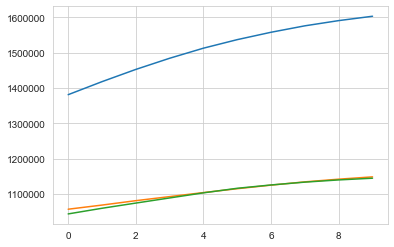

In [38]:
plt.plot(policyF_CR['d'])
plt.plot(policyF_C['d'])
plt.plot(np.array(policyF_S['d'])*2)

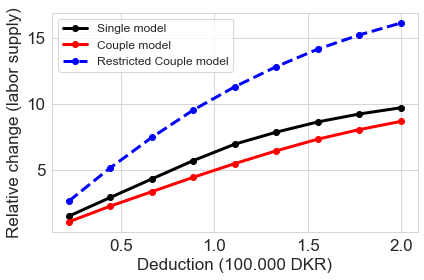

In [40]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.plot_exp(x[1:],Y,ax,names,xlab,ylab)
fig.tight_layout()
fig.savefig('figs/Experiments/DeductionLaborSupply.png')

Clean up

In [ ]:
%reset

# Increase retirement age

Single model

In [2]:
SingleEst = funs.load_est(name='Single')
Single = RetirementClass(SingleEst)
Single.solve()
Single.simulate()

Couple model

In [3]:
CoupleEst,SingleEst = funs.load_est(name='Couple',couple=True)
Couple = RetirementClass(couple=True, single_kwargs=SingleEst, CoupleEst)
Couple.solve()
Couple.simulate()

Restricted Couple model

In [4]:
CoupleRestEst,SingleRestEst = funs.load_est(name='CoupleRest',couple=True)
CoupleRest = RetirementClass(couple=True, single_kwargs=SingleRestEst, CoupleRestEst)
CoupleRest.solve()
CoupleRest.simulate()

Resolve model for different retirement ages

In [6]:
oap = 65
two_year = 62
erp = 60
kwarg_dict = {'oap_age':   [oap, oap+1, oap+2, oap+3, oap+4, oap+5],
              'two_year':  [two_year, two_year+1, two_year+2, two_year+3, two_year+4, two_year+5],
              'erp_age':   [erp, erp+1, erp+2, erp+3, erp+4, erp+5]}
policyRA_S = figs.resolve(Single,vars=['d'],recompute=True, **kwarg_dict)

In [7]:
policyRA_C = figs.resolve_c(Couple,vars=['d'],recompute=True, **kwarg_dict)

MemoryError: 

In [ ]:
policyRA_CR = figs.resolve_c(CoupleRest,vars=['d'],recompute=True, **kwarg_dict)

In [ ]:
x = [1,2,3,4,5]
Yra = [policyRA_S['d'], policyRA_C['d'], policyRA_CR['d']]
for j in range(len(Y)):
    Yra[j] = [(i/Yra[j][0]-1)*100 for i in Yra[j][1:]] # list comprehension to compute relative change
names = ['Single model', 'Couple model', 'Restricted Couple model']
xlab = 'Increase in age (years)'
ylab = 'Relative change (labor supply)'

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
figs.plot_exp(x[1:],Yra,ax,names,xlab,ylab)
fig.tight_layout()
fig.savefig('figs/Experiments/DeductionLaborSupply.png')

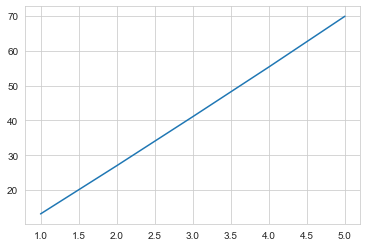

In [49]:
x = [1,2,3,4,5]
y = policy_age['d']
y = [(i/y[0]-1)*100 for i in y[1:]]
plt.plot(x,y)

# Couple model

In [3]:
model = RetirementClass(couple=True)
model.solve()
model.simulate()

In [3]:
fradrag = model.par.fradrag # to reset
x = np.linspace(0,2,10)
policy_fradrag = figs.resolve_c(model,vars=['d'],recompute=True, fradrag=x)
model.par.fradrag = fradrag
model.solve(recompute=True)

In [ ]:
phi_0_male = model.par.phi_0_male
phi_0_female = model.par.phi_0_female
phi_1 = model.par.phi_1
model.par.phi_0_male = 0.0
model.par.phi_0_female = 0.0
model.par.phi_1 = 0.0

policy_fradrag_partial = figs.resolve_c(model,vars=['d'],recompute=True, fradrag=x)
model.par.fradrag = fradrag
model.par.phi_0_male = phi_0_male
model.par.phi_0_female = phi_0_female
model.par.phi_1 = phi_1
model.solve(recompute=True)

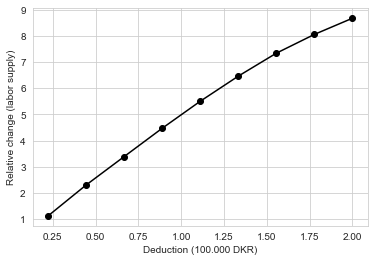

In [23]:
x = np.linspace(0,2,10)
y = policy_fradrag['d']
y = [(i/y[0]-1)*100 for i in y[1:]]
y_partial = policy_fradrag_partial['d']
y_partial = [(i/y_partial[0]-1)*100 for i in y_partial[1:]]
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(x[1:],y,'k-o', label='Baseline')
ax.plot(x[1:],y_partial,'k-o', label='Without complementarities')
ax.set_ylabel('Relative change (labor supply)')
ax.set_xlabel('Deduction (100.000 DKR)')
fig.savefig('figs/experiment_full_couple_fradrag_labor_supply.png')

In [4]:
oap = model.par.oap_age
two_year = model.par.two_year
erp = model.par.erp_age
kwarg_dict = {'oap_age':   [oap, oap+1, oap+2, oap+3, oap+4, oap+5],
              'two_year':  [two_year, two_year+1, two_year+2, two_year+3, two_year+4, two_year+5],
              'erp_age':   [erp, erp+1, erp+2, erp+3, erp+4, erp+5]}
policy_age = figs.resolve_c(model,vars=['d'],recompute=True, **kwarg_dict)
model.par.oap_age = oap
model.par.two_year = two_year
model.par.erp_age = erp
model.solve(recompute=True)

In [5]:
phi_0_male = model.par.phi_0_male
phi_0_female = model.par.phi_0_female
phi_1 = model.par.phi_1
model.par.phi_0_male = 0.0
model.par.phi_0_female = 0.0
model.par.phi_1 = 0.0

policy_age_partial = figs.resolve_c(model,vars=['d'],recompute=True, **kwarg_dict)
model.par.oap_age = oap
model.par.two_year = two_year
model.par.erp_age = erp
model.par.phi_0_male = phi_0_male
model.par.phi_0_female = phi_0_female
model.par.phi_1 = phi_1
model.solve(recompute=True)

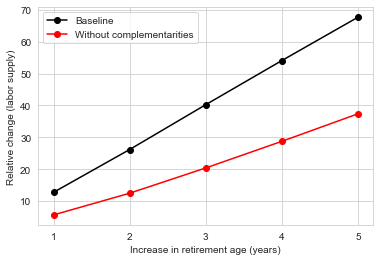

In [16]:
x = [1,2,3,4,5]
y = policy_age['d']
y = [(i/y[0]-1)*100 for i in y[1:]]
y_partial = policy_age_partial['d']
y_partial = [(i/y_partial[0]-1)*100 for i in y_partial[1:]]
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(x,y,'k-o', label='Baseline')
ax.plot(x,y_partial,'r-o', label='Without complementarities')
ax.set_xticks(x)
ax.legend()
ax.set_ylabel('Relative change (labor supply)')
ax.set_xlabel('Increase in retirement age (years)')
fig.savefig('figs/experiment_full_couple_retirement_age_labor_supply.png')